## Supervised Learning with ViT-B architecture with patch size=16

In [2]:
import sys
sys.path.append("../../../ssl")

In [3]:
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.transforms as Transforms
from torch.utils.data import random_split, DataLoader, Dataset
import copy
import pickle
from utils import set_seed
from utils.eval import train
from models.backbone import Backbone
from augmentations.loader import npy_loader
from augmentations import ImageDataset
from models.classifier import Classifier
set_seed(12)

In [4]:
set_seed(12)

eval_transforms = Transforms.Compose([
                # Transforms.ToTensor(), # npy loader returns torch.Tensor
                Transforms.CenterCrop(64),
                Transforms.Normalize(mean = [0.06814773380756378, 0.21582692861557007, 0.4182431399822235],\
                                        std = [0.16798585653305054, 0.5532506108283997, 1.1966736316680908]),
            ])

#--------------------------------------------------------------------------------------------------------

train_test_indices = "../../../input/indices.pkl"
data_path = "../../../input/real_lenses_dataset/"
train_val_split = [0.85, 0.15]

indices = None
with open(train_test_indices, "rb") as f:
    indices = pickle.load(f)
        
#--------------------------------------------------------------------------------------------------------
# get the sizes for train, validation, and test sets
train_val_split = list(train_val_split) / np.sum(list(train_val_split)) 
lens_train_size, nonlens_train_size = int(train_val_split[0] * len(indices["train"]["lenses"])), int(train_val_split[0] * len(indices["train"]["nonlenses"]))
lens_val_size, nonlens_val_size = len(indices["train"]["lenses"]) - lens_train_size, len(indices["train"]["nonlenses"]) - nonlens_train_size
#--------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------
# Split the dataset into train and validation sets

# indices for train and validation datasets
l_idx = np.arange(len(indices["train"]["lenses"]))
nl_idx = np.arange(len(indices["train"]["nonlenses"]))
lens_train_indices = np.random.choice(l_idx, size=lens_train_size, replace=False)
nonlens_train_indices = np.random.choice(nl_idx, size=nonlens_train_size, replace=False)
lens_val_indices = list(set(l_idx) - set(lens_train_indices))
nonlens_val_indices = list(set(nl_idx) - set(nonlens_train_indices))

# train images and labels
train_paths = [os.path.join(data_path, *["lenses", img]) for img in np.array(indices["train"]["lenses"])[lens_train_indices]] +\
                [os.path.join(data_path, *["nonlenses", img]) for img in np.array(indices["train"]["nonlenses"])[nonlens_train_indices]]
train_labels = [0]*len(lens_train_indices) + [1]*len(nonlens_train_indices)

# validation images and labels
val_paths = [os.path.join(data_path, *["lenses", img]) for img in np.array(indices["train"]["lenses"])[lens_val_indices]] +\
                [os.path.join(data_path, *["nonlenses", img]) for img in np.array(indices["train"]["nonlenses"])[nonlens_val_indices]]
val_labels = [0]*len(lens_val_indices) + [1]*len(nonlens_val_indices)

# test images and labels
test_paths = [os.path.join(data_path, *["lenses", img]) for img in np.array(indices["test"]["lenses"])] +\
                [os.path.join(data_path, *["nonlenses", img]) for img in np.array(indices["test"]["nonlenses"])]
test_labels = [0]*len(indices["test"]["lenses"]) + [1]*len(indices["test"]["nonlenses"])

# sizes of the train, validation and test datasets
train_size = len(train_paths)
val_size = len(val_paths)
test_size = len(test_paths)
#--------------------------------------------------------------------------------------------------------

dataset = ImageDataset(
    image_paths=train_paths+val_paths+test_paths,
    labels=train_labels+val_labels+test_labels,
    loader=npy_loader,
    transform=eval_transforms
)
train_dataset = ImageDataset(
    image_paths=train_paths,
    labels=train_labels,
    loader=npy_loader,
    transform=eval_transforms
) 
val_dataset = ImageDataset(
    image_paths=val_paths,
    labels=val_labels,
    loader=npy_loader,
    transform=eval_transforms
)
test_dataset = ImageDataset(
    image_paths=test_paths,
    labels=test_labels,
    loader=npy_loader,
    transform=eval_transforms
)
data_loader = DataLoader(
    dataset,
    batch_size=64,
    num_workers=0,
    shuffle=False,
)
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=False,
)

### Train model over the train dataset

In [5]:
set_seed(12)

lp_network = Classifier(mode = "finetune", backbone = Backbone(arch="vit_base", image_size=64, input_channels=3, patch_size=16))
optimizer = torch.optim.Adam(lp_network.parameters(), lr=1e-4, weight_decay=1e-7)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-9)
# scheduler = None

In [6]:
set_seed(12)

lp_network, lp_network_best_loss = train(lp_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

[1/100] Train Loss: 1.7751, Val Loss: 0.6910, Val Accuracy: 49.40%

[2/100] Train Loss: 0.5906, Val Loss: 0.5452, Val Accuracy: 72.02%

[3/100] Train Loss: 0.4681, Val Loss: 0.3881, Val Accuracy: 83.73%

[4/100] Train Loss: 0.3620, Val Loss: 0.3816, Val Accuracy: 84.13%

[5/100] Train Loss: 0.3555, Val Loss: 0.3145, Val Accuracy: 86.90%

[6/100] Train Loss: 0.2899, Val Loss: 0.2981, Val Accuracy: 86.90%

[7/100] Train Loss: 0.2742, Val Loss: 0.2946, Val Accuracy: 87.50%

[8/100] Train Loss: 0.2537, Val Loss: 0.2910, Val Accuracy: 87.90%

[9/100] Train Loss: 0.2355, Val Loss: 0.2981, Val Accuracy: 87.70%

[10/100] Train Loss: 0.2296, Val Loss: 0.2806, Val Accuracy: 87.50%

[11/100] Train Loss: 0.2620, Val Loss: 0.4120, Val Accuracy: 85.32%

[12/100] Train Loss: 0.3477, Val Loss: 0.2815, Val Accuracy: 88.29%

[13/100] Train Loss: 0.2472, Val Loss: 0.2476, Val Accuracy: 88.89%

[14/100] Train Loss: 0.2206, Val Loss: 0.2349, Val Accuracy: 90.87%

[15/100] Train Loss: 0.1971, Val Loss: 0.23

### Test scores when the model is run on the test dataset 

In [8]:
from utils.eval import test_
output, y_true, acc, auc = test_(lp_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       262        |          31         |
| true nonlenses |        15        |         285         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 92.2428% |
|    loss   |  0.0000  |
| auc score |  0.9762  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9458  | 0.8942 |  0.9193 |   293   |
|   nonlenses    |   0.9019  | 0.9500 |  0.9253 |   300   |
| macro averaged |   0.9239  | 0.9221 |  0.9223 |         |
+----------------+-----------+--------+---------+---------+


In [9]:
state = {
    "network": lp_network,
    "output": output,
    "y_true": y_true,
    "auc": auc,
    "acc": acc
}
with open("./state_vit_base.pth", "wb") as f:
    pickle.dump(state, f)

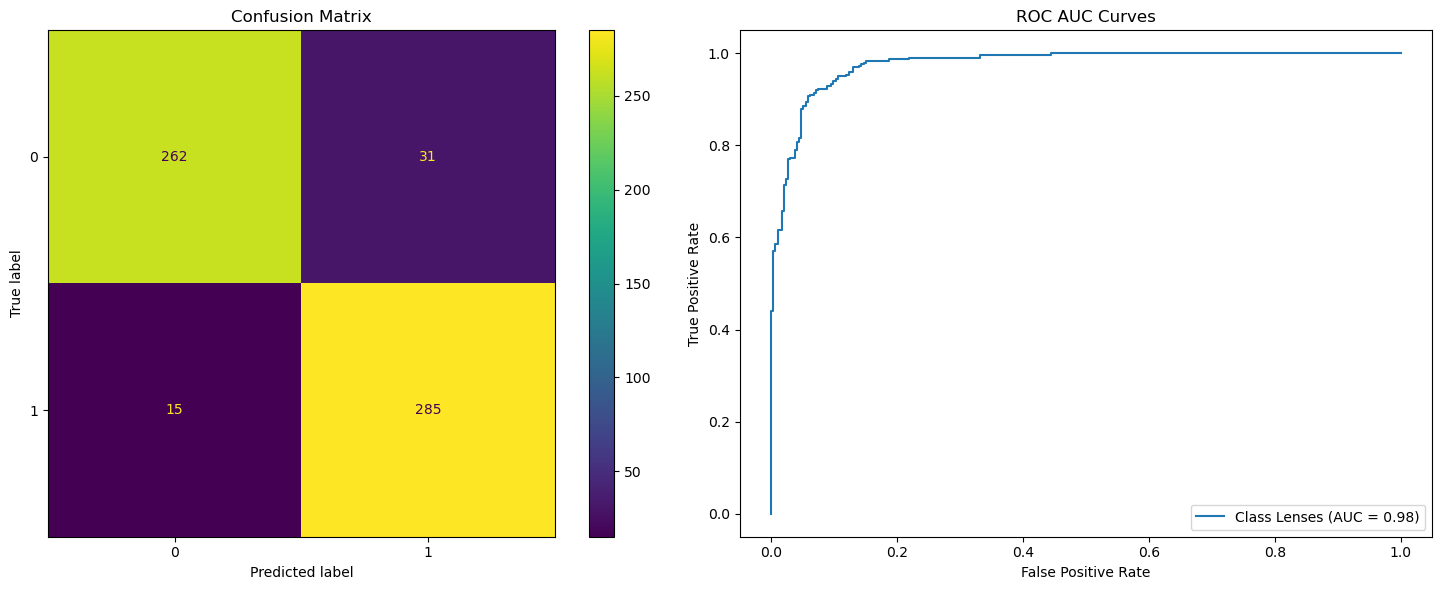

In [10]:
from utils.eval import plot_cm_roc
plot_cm_roc(output, y_true)

### Test scores when the model is run on the entire dataset 

In [11]:
output, y_true, acc, auc = test_(lp_network, data_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       1899       |          50         |
| true nonlenses |        42        |         1958        |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 97.6703% |
|    loss   |  0.0047  |
| auc score |  0.9963  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9784  | 0.9743 |  0.9763 |   1949  |
|   nonlenses    |   0.9751  | 0.9790 |  0.9770 |   2000  |
| macro averaged |   0.9767  | 0.9767 |  0.9767 |         |
+----------------+-----------+--------+---------+---------+
